In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

import pycolmap

# Setup
Here we define some output paths. We will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [2]:
images = Path('datasets/great_man')
outputs = Path('outputs/sift+NN-ratio/')
# !rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['sift']
matcher_conf = match_features.confs['NN-ratio']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

233 mapping images


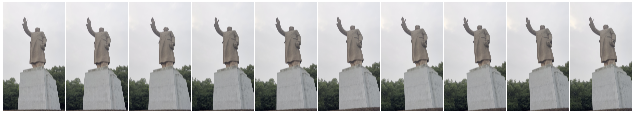

In [3]:
import re

def extract_number(filename):
    # 从文件名中提取数字
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else 0

# 使用自定义排序键对文件名进行排序
references = sorted([str(p.relative_to(images)) for p in (images / 'mapping/').iterdir()], key=extract_number)

print(len(references), "mapping images")
show_imgs = []
for i in range(10):
    show_imgs.append(read_image(images / references[i]))
plot_images(show_imgs, dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [4]:
# 完成重建后注释掉这几行
# extract_features.main(feature_conf, images, image_list=references, feature_path=features)
# pairs_from_exhaustive.main(sfm_pairs, image_list=references)
# match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

The we run incremental Structure-from-Motion...

In [5]:
import time

start = time.time()

# model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references) # 完成重建后注释掉这一行

model = pycolmap.Reconstruction(sfm_dir) # 完成重建后取消注释这一行
end = time.time()

print("reconstruction time: ", end - start, "s")

reconstruction time:  0.15514183044433594 s


and display the reconstructed 3D model:

In [6]:
# print("reconstruction time: ", (end - start)/60, "min")
# reconstruction time:  4.3088978211085 min

In [7]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

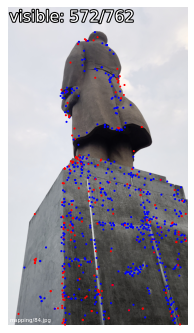

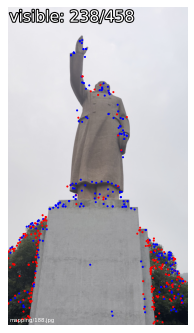

In [8]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

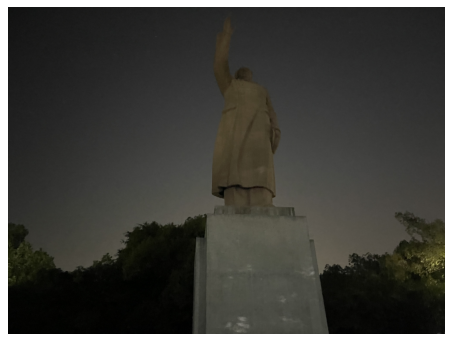

In [9]:
# url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
# !mkdir -p $images/query && wget $url -O $images/$query -q
query = 'query/night.jpg'
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [10]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/12/28 11:05:11 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'dog'},
 'output': 'feats-sift',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/12/28 11:05:11 hloc INFO] Finished exporting features.
[2023/12/28 11:05:11 hloc INFO] Found 233 pairs.
[2023/12/28 11:05:11 hloc INFO] Matching local features with configuration:
{'model': {'do_mutual_check': True,
           'name': 'nearest_neighbor',
           'ratio_threshold': 0.8},
 'output': 'matches-NN-mutual-ratio.8'}


  0%|          | 0/233 [00:00<?, ?it/s]

[2023/12/28 11:05:20 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 20/240 inlier correspondences.


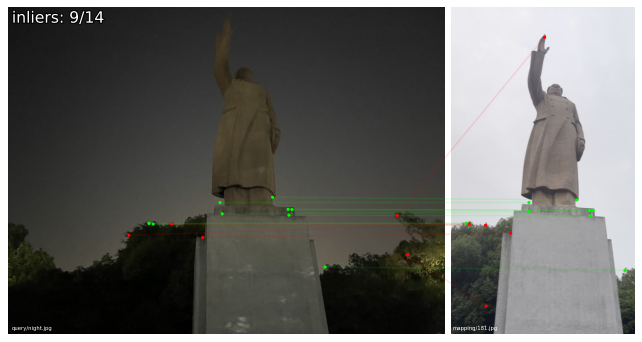

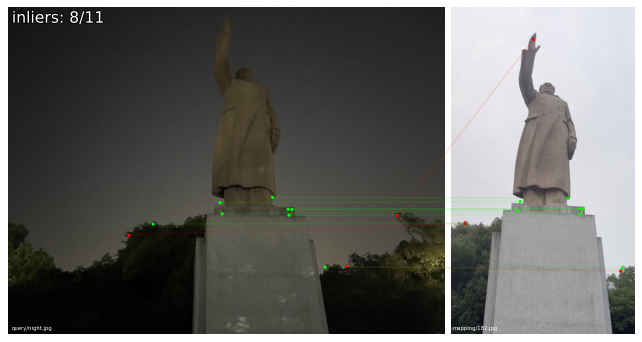

In [11]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [12]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
import numpy as np
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()

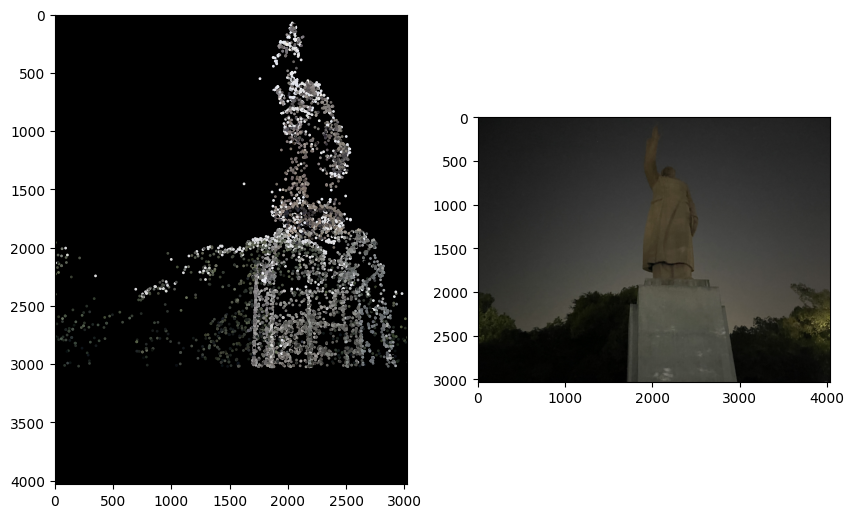

In [13]:
# project cloud to image
from utils import *

project_cloud_to_image(model, camera, images, query, ret)

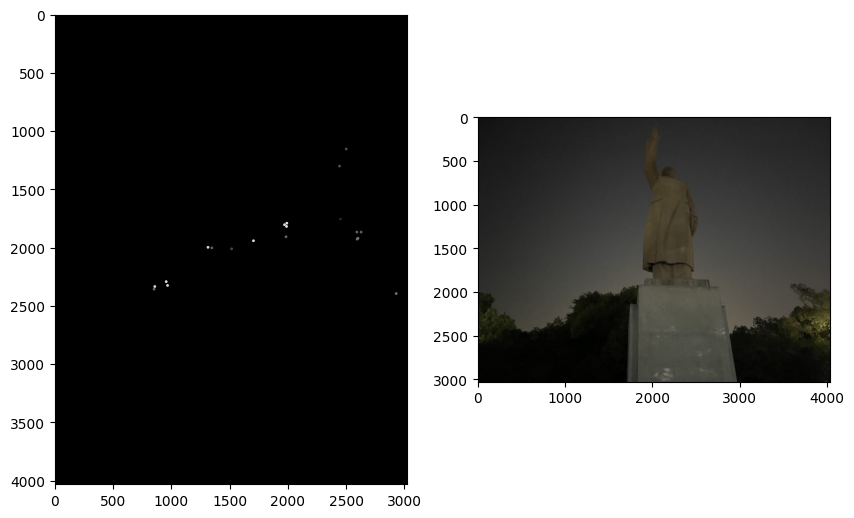

In [14]:
project_feature_cloud_to_image(model, camera, images, query, ret, log)

save image to ./test/wide/projection_sift+NN-ratio.png


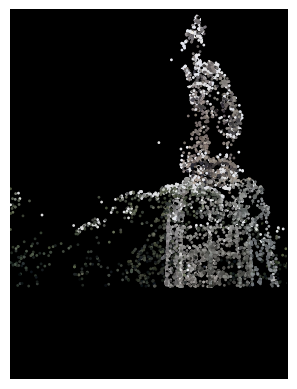

save image to ./test/wide/feature_sift+NN-ratio.png


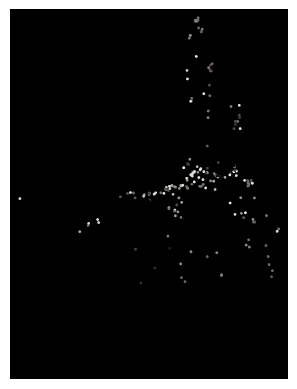

(240, 2)
(3024, 4032, 3)
save image to ./test/wide/origin_features_sift+NN-ratio.png


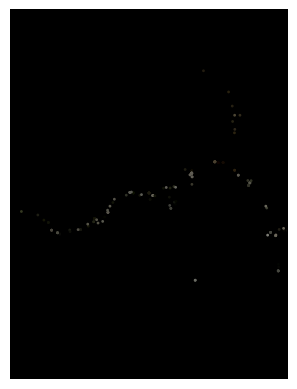

0.418701171875
0.962340011173731


In [15]:
test_image_name = 'wide'
import os
if not os.path.exists(f'./test/{test_image_name}'):
    os.makedirs(f'./test/{test_image_name}')
src_path = f'./test/{test_image_name}/origin_features_sift+NN-ratio.png'
dst_path = f'./test/{test_image_name}/feature_sift+NN-ratio.png'
save_cloud_to_image(model, camera, ret, f'./test/{test_image_name}/projection_sift+NN-ratio.png')
save_feature_cloud_to_image(model, camera, ret, log, dst_path)
save_origin_features_within_cloud(images, query, ret, log, camera, src_path)


print(location_evaluate(src_path, dst_path))
print(ssim_evaluate(src_path, dst_path))